In [1]:
import numpy as np
import pandas as pd
from nltk import word_tokenize, sent_tokenize
from string import punctuation
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## EDA

In [2]:
columns = ['id','label','statement','subject','speaker','job title','state info','party','barely true','false','half-true','mostly-true','pants-on-fire','context']
label_map = {'pants-fire':-3, 'false':-2, 'barely-true':-1, 'half-true':1, 'mostly-true':2, 'true':3}

In [3]:
train = pd.read_csv('train.tsv',sep='\t',header=None,names=columns)
valid = pd.read_csv('valid.tsv',sep='\t',header=None,names=columns)
test =  pd.read_csv('test.tsv',sep='\t',header=None,names=columns)

In [4]:
train.shape,test.shape,valid.shape

((10240, 14), (1267, 14), (1284, 14))

In [5]:
print(train.label.unique())

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [6]:
train.head()

,id,label,statement,subject,speaker,job title,state info,party,barely true,false,half-true,mostly-true,pants-on-fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10240 non-null  object 
 1   label          10240 non-null  object 
 2   statement      10240 non-null  object 
 3   subject        10238 non-null  object 
 4   speaker        10238 non-null  object 
 5   job title      7343 non-null   object 
 6   state info     8032 non-null   object 
 7   party          10238 non-null  object 
 8   barely true    10238 non-null  float64
 9   false          10238 non-null  float64
 10  half-true      10238 non-null  float64
 11  mostly-true    10238 non-null  float64
 12  pants-on-fire  10238 non-null  float64
 13  context        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [8]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1284 non-null   object
 1   label          1284 non-null   object
 2   statement      1284 non-null   object
 3   subject        1284 non-null   object
 4   speaker        1284 non-null   object
 5   job title      939 non-null    object
 6   state info     1005 non-null   object
 7   party          1284 non-null   object
 8   barely true    1284 non-null   int64 
 9   false          1284 non-null   int64 
 10  half-true      1284 non-null   int64 
 11  mostly-true    1284 non-null   int64 
 12  pants-on-fire  1284 non-null   int64 
 13  context        1272 non-null   object
dtypes: int64(5), object(9)
memory usage: 140.6+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1267 non-null   object
 1   label          1267 non-null   object
 2   statement      1267 non-null   object
 3   subject        1267 non-null   object
 4   speaker        1267 non-null   object
 5   job title      942 non-null    object
 6   state info     1005 non-null   object
 7   party          1267 non-null   object
 8   barely true    1267 non-null   int64 
 9   false          1267 non-null   int64 
 10  half-true      1267 non-null   int64 
 11  mostly-true    1267 non-null   int64 
 12  pants-on-fire  1267 non-null   int64 
 13  context        1250 non-null   object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB


In [10]:
data = pd.concat([train,test,valid])
data = data.drop(columns=['id'])
data.head()

,label,statement,subject,speaker,job title,state info,party,barely true,false,half-true,mostly-true,pants-on-fire,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


<AxesSubplot: xlabel='label', ylabel='count'>

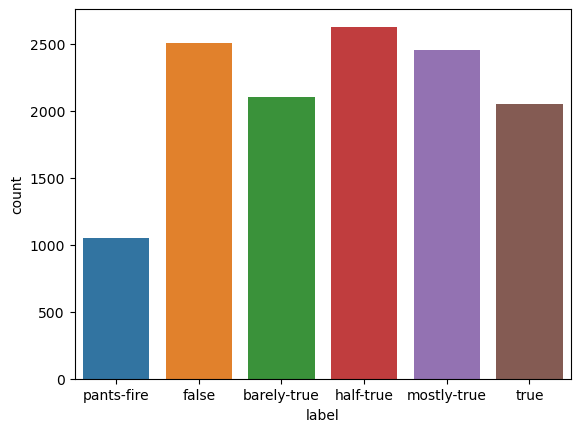

In [11]:
# Plots the count of observations in the 'label' column of the data DataFrame, ordered from 'pants-fire' to 'true'.
label_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
sns.countplot(data=data, x='label', order=label_order)

In [12]:
# displays count of each label category for Job titles

# president
arr = data[data['job title']=='President']['label'].value_counts()
print(pd.DataFrame(arr))

             label
half-true      166
mostly-true    164
true           124
false           82
barely-true     70
pants-fire       9
